In [24]:
import cv2 
import numpy as np

import os
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.optim import Adam, LBFGS
from torch.autograd import Variable

from collections import namedtuple
import torch
from torchvision import models
import PIL
import torchvision.transforms as T

import warnings
warnings.filterwarnings("ignore")

# reconstruct content/style image 

steps:

1. read input image make it in size to feed model and tranform as vgg required.
2. make noise image of same size as above , need to change this with grads so define it as varibale and require grad true.
3. load vgg model defined with required grad false, pretrained true
4. if content need to define layer which we work on like relu_1_2 based on vgg
5. use optimizer lbfgs recommended if no gpu issues, else adam.
6. define forward such that get layers which is needed for feature maps both in content/style
7. Here can visualize ouput of layers we work on as feature maps
8. define gram matrix and loss functions for content and style
9. loop based on config iteration to minimize corresponding loss, can store each step output image as well
10. after completion save final output

In [2]:
# config defined

input_image=r"D:\project\computer_vision\deep_learning\neural_style_transfer\data\content-images\figures.jpg"
output_dir=r"D:\project\computer_vision\deep_learning\neural_style_transfer\data\output"
in_process_output=r"D:\project\computer_vision\deep_learning\neural_style_transfer\data\output\in_process"

num_of_iterations = {'adam': 3000, 'lbfgs': 350}
config_optimizer = 'adam' #"lbfgs"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cpu


In [5]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f'Path does not exist: {img_path}')
    img = cv2.imread(img_path)[:, :, ::-1]  # [:, :, ::-1] converts BGR (opencv format...) into RGB

    if target_shape is not None:  # resize section
        if isinstance(target_shape, int) and target_shape != -1:  # scalar -> implicitly setting the height
            current_height, current_width = img.shape[:2]
            new_height = target_shape
            new_width = int(current_width * (new_height / current_height))
            img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv2.resize(img, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_CUBIC)

    # this need to go after resizing - otherwise cv.resize will push values outside of [0,1] range
    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range
    return img



In [6]:
def prepare_img(img_path, target_shape, device):
    img = load_image(img_path, target_shape=target_shape)

    # normalize using ImageNet's mean
    # [0, 255] range worked much better for me than [0, 1] range (even though PyTorch models were trained on latter)
    IMAGENET_MEAN_255 = [123.675, 116.28, 103.53]
    IMAGENET_STD_NEUTRAL = [1, 1, 1]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)
    ])

    img = transform(img).to(device).unsqueeze(0)

    return img

In [29]:
img = prepare_img(input_image, 500, device)

gaussian_noise_img = np.random.normal(loc=0, scale=90., size=img.shape).astype(np.float32)
white_noise_img = np.random.uniform(-90., 90., img.shape).astype(np.float32)
init_img = torch.from_numpy(white_noise_img).float().to(device)
optimizing_img = Variable(init_img, requires_grad=True)


In [30]:
print(img.shape)

torch.Size([1, 3, 500, 750])


In [14]:
init_img

tensor([[[[-4.8347e+01, -5.8304e+01,  5.4034e+01,  ..., -3.8438e+01,
            4.2916e+01, -4.6631e+01],
          [ 6.8857e+00,  6.2986e+00,  6.7615e+01,  ..., -3.6724e+01,
           -4.7504e+01,  6.2538e+00],
          [ 2.5441e+01, -4.0001e+01, -3.6670e+01,  ...,  8.9967e+01,
            7.6188e+01, -5.8807e+01],
          ...,
          [-3.5765e+01,  7.9226e+01, -9.9264e+00,  ...,  8.7211e+01,
           -5.2316e+01, -4.4800e+00],
          [-6.8151e+01, -8.1954e+01,  6.1949e+01,  ..., -5.2601e+01,
           -7.6203e+01,  6.3383e+01],
          [-3.3632e+00,  6.4103e+01,  8.2953e+01,  ..., -8.5197e+01,
            6.5190e+01,  6.3621e+01]],

         [[-4.8321e+01,  5.5275e+01,  4.5918e+00,  ..., -4.6814e-02,
            5.7802e+01, -6.9712e+01],
          [ 3.4578e+01, -4.5812e+01, -6.0033e+01,  ...,  6.0738e+01,
           -3.2578e+00, -5.1889e+01],
          [-1.2029e+01,  7.0153e+01,  4.5597e+01,  ...,  8.3294e+01,
            4.3939e+01, -4.1993e+01],
          ...,
     

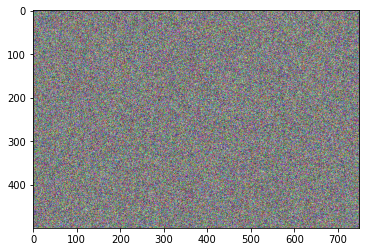

In [28]:
# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()

# convert the tensor to PIL image using above transform
noise_img = transform(init_img.reshape([3, 500, 750]))

plt.imshow(noise_img)
plt.show()
#tensor_to_image(init_img)

In [21]:
class Vgg16(torch.nn.Module):
    """Only those layers are exposed which have already proven to work nicely."""
    def __init__(self, requires_grad=False, show_progress=False):
        super().__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True, progress=show_progress).features
        self.layer_names = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
        self.content_feature_maps_index = 1  # relu2_2
        self.style_feature_maps_indices = list(range(len(self.layer_names)))  # all layers used for style representation

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.slice1(x)
        relu1_2 = x
        x = self.slice2(x)
        relu2_2 = x
        x = self.slice3(x)
        relu3_3 = x
        x = self.slice4(x)
        relu4_3 = x
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(relu1_2, relu2_2, relu3_3, relu4_3)
        return out

In [22]:
def gram_matrix(x, should_normalize=True):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t)
    if should_normalize:
        gram /= ch * h * w
    return gram

In [26]:
model = Vgg16(requires_grad=False, show_progress=True)


content_feature_maps_index = model.content_feature_maps_index
style_feature_maps_indices = model.style_feature_maps_indices
layer_names = model.layer_names

content_feature_maps_index_name = (content_feature_maps_index, layer_names[content_feature_maps_index])
style_feature_maps_indices_names = (style_feature_maps_indices, layer_names)

neural_net=model.to(device).eval()



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\akhil/.cache\torch\hub\checkpoints\vgg16-397923af.pth


In [31]:
set_of_feature_maps = neural_net(img)

target_content_representation = set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0)
target_style_representation = [gram_matrix(fmaps) for i, fmaps in enumerate(set_of_feature_maps) if i in style_feature_maps_indices_names[0]]

In [ ]:
#feature map visualization content
num_of_feature_maps = target_content_representation.size()[0]
print(f'Number of feature maps: {num_of_feature_maps}')
for i in range(num_of_feature_maps):
    feature_map = target_content_representation[i].to('cpu').numpy()
    feature_map = np.uint8(utils.get_uint8_range(feature_map))
    plt.imshow(feature_map)
    plt.title(f'Feature map {i+1}/{num_of_feature_maps} from layer {content_feature_maps_index_name[1]} (model={config["model"]}) for {config["content_img_name"]} image.')
    plt.show()
    filename = f'fm_{config["model"]}_{content_feature_maps_index_name[1]}_{str(i).zfill(config["img_format"][0])}{config["img_format"][1]}'
    #utils.save_image(feature_map, os.path.join(dump_path, filename))

In [ ]:
# style gram matrix visualization
num_of_gram_matrices = len(target_style_representation)
print(f'Number of Gram matrices: {num_of_gram_matrices}')
for i in range(num_of_gram_matrices):
    Gram_matrix = target_style_representation[i].squeeze(axis=0).to('cpu').numpy()
    Gram_matrix = np.uint8(utils.get_uint8_range(Gram_matrix))
    plt.imshow(Gram_matrix)
    plt.title(f'Gram matrix from layer {style_feature_maps_indices_names[1][i]} (model={config["model"]}) for {config["style_img_name"]} image.')
    plt.show()
    filename = f'gram_{config["model"]}_{style_feature_maps_indices_names[1][i]}_{str(i).zfill(config["img_format"][0])}{config["img_format"][1]}'
    #utils.save_image(Gram_matrix, os.path.join(dump_path, filename))


In [ ]:
def make_tuning_step(model, optimizer, target_representation, should_reconstruct_content, content_feature_maps_index, style_feature_maps_indices):
    # Builds function that performs a step in the tuning loop
    def tuning_step(optimizing_img):
        # Finds the current representation
        set_of_feature_maps = model(optimizing_img)
        if should_reconstruct_content:
            current_representation = set_of_feature_maps[content_feature_maps_index].squeeze(axis=0)
        else:
            current_representation = [utils.gram_matrix(fmaps) for i, fmaps in enumerate(set_of_feature_maps) if i in style_feature_maps_indices]

        # Computes the loss between current and target representations
        loss = 0.0
        if should_reconstruct_content:
            loss = torch.nn.MSELoss(reduction='mean')(target_representation, current_representation)
        else:
            for gram_gt, gram_hat in zip(target_representation, current_representation):
                loss += (1 / len(target_representation)) * torch.nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])

        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item(), current_representation

    # Returns the function that will be called inside the tuning loop
    return tuning_step

In [ ]:
if config_optimizer == 'adam':
        optimizer = Adam((optimizing_img,))
        target_representation = target_content_representation 
        tuning_step = make_tuning_step(neural_net, optimizer, target_representation, should_reconstruct_content, content_feature_maps_index_name[0], style_feature_maps_indices_names[0])
        for it in range(num_of_iterations[config_optimizer]):
            loss, _ = tuning_step(optimizing_img)
            with torch.no_grad():
                print(f'Iteration: {it}, current {"content" if should_reconstruct_content else "style"} loss={loss:10.8f}')
                #utils.save_and_maybe_display(optimizing_img, dump_path, config, it, num_of_iterations[config['optimizer']], should_display=False)